<a href="https://colab.research.google.com/github/ManuSharma0702/finetuning_mobileNet/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget "https://drive.usercontent.google.com/download?id=1OGKii4EcgEr1i1goEnAeHW4soEg484Hr&export=download&authuser=0&confirm=t&uuid=86ccb189-e445-4455-8820-45d48831d250&at=APZUnTWubBhtH667k9NL3grNBTn_:1720128287970"

--2024-07-04 23:03:19--  https://drive.usercontent.google.com/download?id=1OGKii4EcgEr1i1goEnAeHW4soEg484Hr&export=download&authuser=0&confirm=t&uuid=86ccb189-e445-4455-8820-45d48831d250&at=APZUnTWubBhtH667k9NL3grNBTn_:1720128287970
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24457047 (23M) [application/octet-stream]
Saving to: ‘download?id=1OGKii4EcgEr1i1goEnAeHW4soEg484Hr&export=download&authuser=0&confirm=t&uuid=86ccb189-e445-4455-8820-45d48831d250&at=APZUnTWubBhtH667k9NL3grNBTn_:1720128287970’

download?id=1OGKii4 100%[===================>]  23.32M  17.7MB/s    in 1.3s    

2024-07-04 23:03:34 (17.7 MB/s) - ‘download?id=1OGKii4EcgEr1i1goEnAeHW4soEg484Hr&export=download&authuser=0&confirm=t&uuid=86ccb189-e445-4455-8820-45d48831d250&at=APZUnTWubBhtH667k9NL3gr

In [ ]:
import zipfile
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
import os

current_directory = os.getcwd()

print(f'The current working directory is: {current_directory}')

The current working directory is: /content


In [ ]:
os.chdir("/content/data")

In [ ]:
if os.path.isdir('train/0/') is False:
  os.mkdir('train')
  os.mkdir('valid')
  os.mkdir('test')


In [ ]:
for i in range(10):
  shutil.move(f'{i}', "train")
  os.mkdir(f'valid/{i}')
  os.mkdir(f'test/{i}')
  valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
  for j in valid_samples:
    shutil.move(f'train/{i}/{j}', f'valid/{i}')

  test_samples = random.sample(os.listdir(f'train/{i}'), 5)
  for j in test_samples:
    shutil.move(f'train/{i}/{j}', f'test/{i}')
os.chdir('../..')


In [ ]:
train_path = 'content/data/train'
valid_path = 'content/data/valid'
test_path = 'content/data/test'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
x = mobile.layers[-5].output

x = tf.keras.layers.Reshape(target_shape=(1024,))(x)

output = Dense(units=10, activation='softmax')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-10]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)


Epoch 1/10
172/172 - 7s - loss: 0.8651 - accuracy: 0.7307 - val_loss: 0.6585 - val_accuracy: 0.7800 - 7s/epoch - 43ms/step
Epoch 2/10
172/172 - 4s - loss: 0.2525 - accuracy: 0.9468 - val_loss: 0.2311 - val_accuracy: 0.9467 - 4s/epoch - 21ms/step
Epoch 3/10
172/172 - 4s - loss: 0.1562 - accuracy: 0.9807 - val_loss: 0.1443 - val_accuracy: 0.9700 - 4s/epoch - 21ms/step
Epoch 4/10
172/172 - 5s - loss: 0.1008 - accuracy: 0.9871 - val_loss: 0.1181 - val_accuracy: 0.9700 - 5s/epoch - 28ms/step
Epoch 5/10
172/172 - 7s - loss: 0.0707 - accuracy: 0.9947 - val_loss: 0.0950 - val_accuracy: 0.9867 - 7s/epoch - 38ms/step
Epoch 6/10
172/172 - 8s - loss: 0.0574 - accuracy: 0.9947 - val_loss: 0.0878 - val_accuracy: 0.9767 - 8s/epoch - 47ms/step
Epoch 7/10
172/172 - 4s - loss: 0.0497 - accuracy: 0.9947 - val_loss: 0.0827 - val_accuracy: 0.9800 - 4s/epoch - 23ms/step
Epoch 8/10
172/172 - 4s - loss: 0.0338 - accuracy: 0.9965 - val_loss: 0.0747 - val_accuracy: 0.9900 - 4s/epoch - 23ms/step
Epoch 9/10
172/1

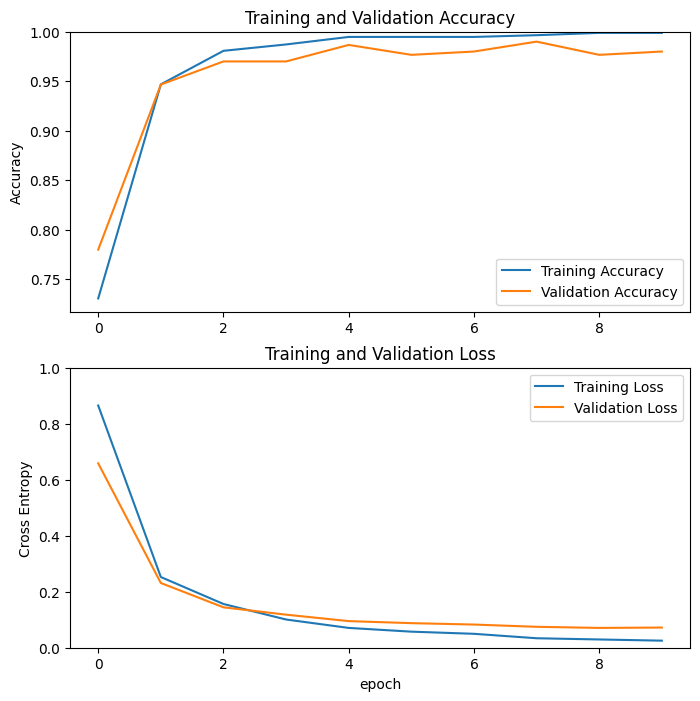

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 1 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


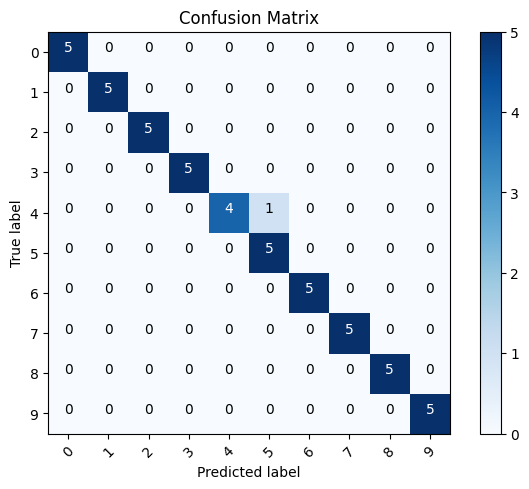

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')